<a href="https://colab.research.google.com/github/cmnemoi/Ballond-OrPrediction/blob/main/predict_top_3_scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will try to predict top 3 scores here

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/cmmm976/Ballond-OrPrediction/main/data/merged_data.csv")

In [ ]:
data.dropna(axis=0,subset=["%"],inplace=True)
data = data[data["Rang"] <= 3]
data.reset_index(drop=True,inplace=True)

In [ ]:
data.shape

(59, 59)

Very low amount of data, let's make sure to make data representative in training and test sets with stratified splitting


# Encoding categorical variables

In [ ]:
data['score_cat'] = pd.cut(data['%'].astype(float), 
                          bins=[5.,10., 15, 20., 25., 30., 35., np.inf],
                          labels=[1, 2, 3, 4, 5,6,7])

In [ ]:
data['score_cat'].head(5)

0    2
1    3
2    2
3    5
4    1
Name: score_cat, dtype: category
Categories (7, int64): [1 < 2 < 3 < 4 < 5 < 6 < 7]

In [ ]:
X = data[['Nation', 'Pos', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY', 'CrdR','winner_Bundesliga',
       'winner_C3', 'finalist_C3', 'winner_UCL', 'finalist_UCL',
       'winner_Club WC', 'finalist_Club WC', 'winner_Copa America',
       'finalist_Copa America', 'winner_Euro', 'finalist_Euro', 'winner_Liga',
       'winner_Ligue 1', 'winner_PL', 'winner_Serie A', 'winner_WC',
       'finalist_WC']]
y = data[['%']].astype(float)

In [ ]:
import sklearn.preprocessing

encoder = sklearn.preprocessing.OrdinalEncoder()
X['Pos'] = encoder.fit_transform(X[['Pos']])
X['Nation'] = encoder.fit_transform(X[['Nation']])

## Train test split

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=.3, random_state=0)

for train_index, test_index in stratified_split.split(data, data['score_cat']):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [ ]:
strat_test_set['score_cat'].value_counts() / len(strat_test_set)

3    0.277778
4    0.222222
2    0.166667
6    0.111111
5    0.111111
7    0.055556
1    0.055556
Name: score_cat, dtype: float64

In [ ]:
strat_train_set['score_cat'].value_counts() / len(strat_train_set)

3    0.317073
4    0.219512
2    0.170732
7    0.073171
6    0.073171
5    0.073171
1    0.073171
Name: score_cat, dtype: float64

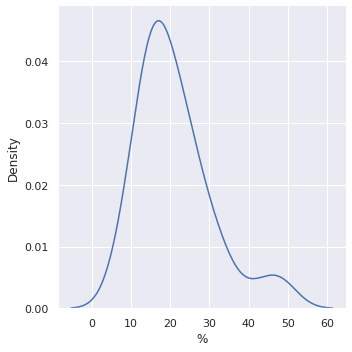

In [ ]:
sns.displot(x=strat_train_set['%'].astype(float),kind="kde")

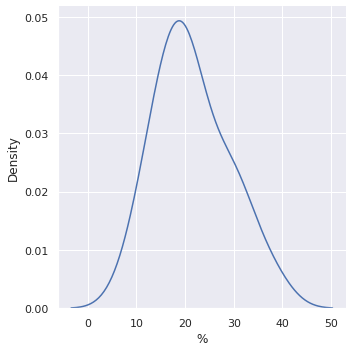

In [ ]:
sns.displot(x=strat_test_set['%'].astype(float),kind="kde")

Re-encoding

In [ ]:
X_train = strat_train_set[['Nation', 'Pos', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY', 'CrdR','winner_Bundesliga',
       'winner_C3', 'finalist_C3', 'winner_UCL', 'finalist_UCL',
       'winner_Club WC', 'finalist_Club WC', 'winner_Copa America',
       'finalist_Copa America', 'winner_Euro', 'finalist_Euro', 'winner_Liga',
       'winner_Ligue 1', 'winner_PL', 'winner_Serie A', 'winner_WC',
       'finalist_WC']]
X_test = strat_test_set[['Nation', 'Pos', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY', 'CrdR','winner_Bundesliga',
       'winner_C3', 'finalist_C3', 'winner_UCL', 'finalist_UCL',
       'winner_Club WC', 'finalist_Club WC', 'winner_Copa America',
       'finalist_Copa America', 'winner_Euro', 'finalist_Euro', 'winner_Liga',
       'winner_Ligue 1', 'winner_PL', 'winner_Serie A', 'winner_WC',
       'finalist_WC']]
y_train = strat_train_set[['%']].astype(float)
y_test = strat_test_set[['%']].astype(float)

In [ ]:
y_train['%'].mean() / y_test['%'].mean()

0.980930046755998

In [ ]:
y_train['%'].std() / y_test['%'].std()

1.2693621412447675

In [ ]:
import sklearn.preprocessing

encoder = sklearn.preprocessing.OrdinalEncoder()
X_train['Pos'] = encoder.fit_transform(X_train[['Pos']])
X_train['Nation'] = encoder.fit_transform(X_train[['Nation']])

X_test['Pos'] = encoder.fit_transform(X_test[['Pos']])
X_test['Nation'] = encoder.fit_transform(X_test[['Nation']])


Preprocessing

Imputing missing values

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3, weights="uniform")
X_train = pd.DataFrame(imputer.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(imputer.fit_transform(X_test),columns=X_test.columns)

Data Augmentation

In [ ]:
def noise(X, y, n, sigma):
    _X = X.copy()
    _y = y.copy()
    for _ in range(n):
        X = np.r_[X, _X + np.random.randn(*_X.shape)*sigma]
        y = np.r_[y, _y]
    return X, y

In [ ]:
X_train_augmented, y_train_augmented = noise(X_train, y_train,60, 2)
X_train_augmented = pd.DataFrame(X_train_augmented,columns=X_train.columns)
y_train_augmented = pd.DataFrame(y_train_augmented,columns=y_train.columns)

In [ ]:
X_train_augmented.shape

(2501, 25)

Standardisation

In [ ]:
X_train_standardized = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(X_train),columns=X_train.columns)
X_train_augmented_standardized = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(X_train_augmented),columns=X_train.columns)

# Model building

In [ ]:
from sklearn.model_selection import learning_curve

def print_learning_curve(model,X=X_train_augmented_standardized,y=y_train_augmented,score='neg_root_mean_squared_error'):
    N, train_score, val_score = learning_curve(model, X,y, train_sizes=np.linspace(0.1,1,10),cv=10,scoring=score)
    plt.plot(N[1:], abs(train_score.mean(axis=1))[1:],label="train")
    plt.plot(N[1:], abs(val_score.mean(axis=1))[1:], label="validation")
    plt.xlabel('train_sizes')
    plt.legend()

    mean_train_score = abs(train_score.mean(axis=1))[9]
    mean_val_score = abs(val_score.mean(axis=1))[9]

    train_percent_of_mean = mean_train_score * 100 / y['%'].mean()
    val_percent_of_mean = mean_val_score *100 / y['%'].mean()

    # train_percent_of_std = abs(mean_train_score-y.std()) * 100 / y.std()
    # val_percent_of_mean = mean_val_score * 100 / y.std()

    print("Training RMSE : "+str(mean_train_score)+ " ("+str(train_percent_of_mean)+"% of the mean)")
    print("Validation RMSE : "+str(mean_val_score)+ " ("+str(val_percent_of_mean)+"% of the mean)")

In [ ]:
y_train_augmented.std()

8.389949739771268

## Linear regression

Training RMSE : 8.054040831927843 (38.239568342570664% of the mean)
Validation RMSE : 8.11872267190277 (38.546669547029346% of the mean)


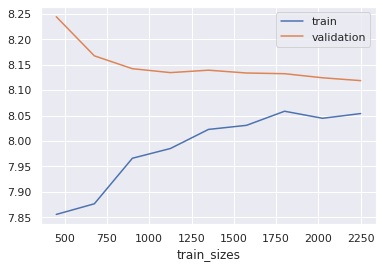

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve

print_learning_curve(LinearRegression())

## Ridge Regression

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

ridge = RidgeCV(alphas = np.linspace(10,500),cv=10,scoring='neg_root_mean_squared_error').fit(X_train_augmented_standardized,y_train_augmented)
print(ridge.alpha_)

90.0


Training RMSE : 8.055270608321155 (38.24540716551924% of the mean)
Validation RMSE : 8.11748188183915 (38.54077843256561% of the mean)


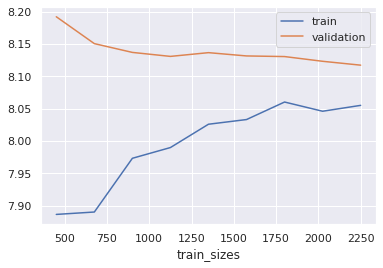

In [ ]:
print_learning_curve(Ridge(alpha=90.0))

## Lasso Regression

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

lasso = LassoCV(alphas = np.linspace(-5,5),cv=10).fit(X_train_augmented_standardized,y_train_augmented)
print(lasso.alpha_)

0.1020408163265305


Training RMSE : 8.067690773677509 (38.3043765414985% of the mean)
Validation RMSE : 8.117981650135668 (38.543151269297994% of the mean)


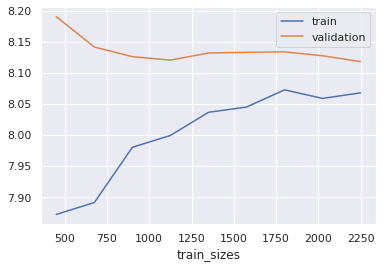

In [ ]:
print_learning_curve(Lasso(alpha=0.1020408163265305))

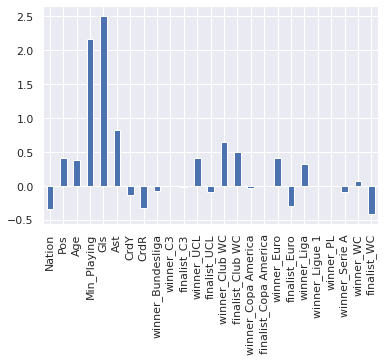

In [ ]:
lasso_coef = pd.Series(lasso.coef_,index=X.columns)

lasso_coef.plot.bar()

## Polynomial regression

Training RMSE : 6.2989624311934795 (29.90667782810989% of the mean)
Validation RMSE : 7.423004584873285 (35.243487965100556% of the mean)


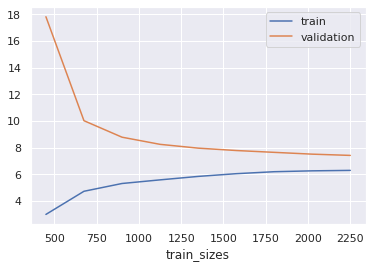

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_augmented_standardized)

print_learning_curve(LinearRegression(),X=X_train_poly)

Training RMSE : 7.75188835216753e-14 (3.6804986541859083e-13% of the mean)
Validation RMSE : 18.464991143597114 (87.6694451288908% of the mean)


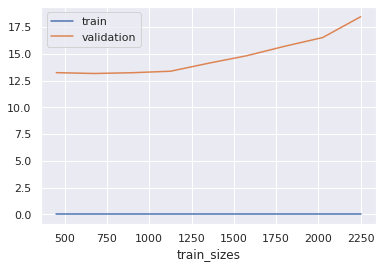

In [ ]:
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train_augmented_standardized)

print_learning_curve(LinearRegression(),X=X_train_poly)

degree 2 : 6.13 -> 29% RMSE (validation)
 
degree 3 : 21.75 -> 102% RMSE (validation)

trying regularisation on R_3[X] regression

In [ ]:
print_learning_curve(Ridge(alpha=5000),X_train_poly,y_train_augmented)

In [ ]:
from sklearn.model_selection import cross_val_score

for a in tqdm(range(18,22)):
    print(a/100,cross_val_score(Lasso(a/100),X_train_poly,y_train_augmented,cv=10,scoring="neg_root_mean_squared_error").mean())

 25%|██▌       | 1/4 [00:05<00:17,  5.90s/it]

0.18 -6.465328598069886


 50%|█████     | 2/4 [00:11<00:11,  5.94s/it]

0.19 -6.4638202210807005


 75%|███████▌  | 3/4 [00:17<00:05,  5.98s/it]

0.2 -6.465480923250605


100%|██████████| 4/4 [00:23<00:00,  5.93s/it]

0.21 -6.4694957685070635


Training RMSE : 5.448228926486389 (25.86750262730891% of the mean)
Validation RMSE : 6.467645083343515 (30.70756174957287% of the mean)


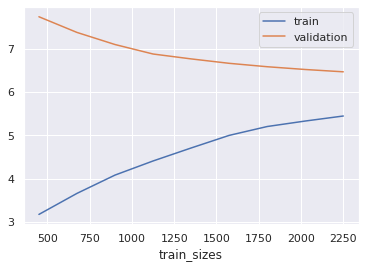

In [ ]:
print_learning_curve(Lasso(alpha=0.19),X_train_poly,y_train_augmented)

## Non linear methods

Training RMSE : 3.082357137756323 (14.634642272757157% of the mean)
Validation RMSE : 7.122952574056141 (33.818878925563126% of the mean)


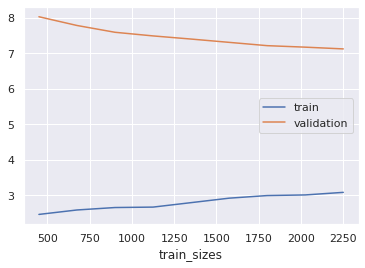

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

parameters = {"C":np.linspace(6,30)}

svr = GridSearchCV(SVR(),parameters).fit(X_train_augmented_standardized,y_train_augmented)

print_learning_curve(svr.best_estimator_)

In [ ]:
svr.best_estimator_

SVR(C=30.0)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[500,1000],
                'min_samples_leaf':[4,5,6],
                'max_features':["sqrt",X_train.shape[0]/3]}

grid = GridSearchCV(RandomForestRegressor(),parameters).fit(X_train_augmented,y_train_augmented)

In [ ]:
grid.best_estimator_

RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      n_estimators=1000)

Training RMSE : 2.779808673911293 (13.198180389638976% of the mean)
Validation RMSE : 4.544913049458669 (21.578672965855297% of the mean)


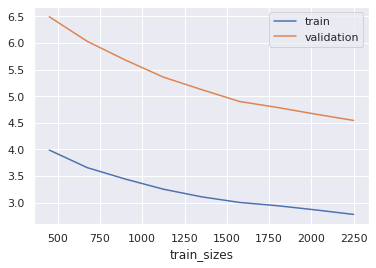

In [ ]:
print_learning_curve(RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      n_estimators=500,random_state=0))

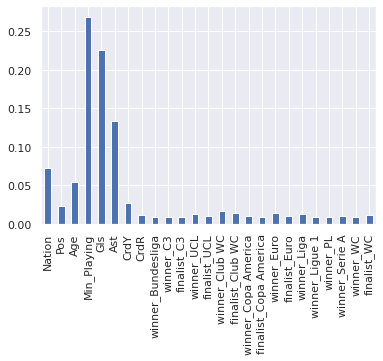

In [ ]:
importances = grid.best_estimator_.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

forest_importances.plot.bar()

In [ ]:
parameters = {'min_samples_leaf':[2,3,4],
                'max_depth':[4,5,6,7,8,9,None],'n_estimators':[1000]}

grid = GridSearchCV(RandomForestRegressor(),parameters).fit(X_train_augmented,y_train_augmented)

In [ ]:
grid.best_estimator_

RandomForestRegressor(min_samples_leaf=2, n_estimators=1000)

In [ ]:
parameters = {'min_samples_leaf':[2],
                'max_depth':[9,None],'n_estimators':[500]}

grid = GridSearchCV(RandomForestRegressor(),parameters).fit(X_train_augmented,y_train_augmented)

In [ ]:
grid.best_estimator_

Training RMSE : 2.004910256763338 (9.519060603753024% of the mean)
Validation RMSE : 4.276345809632604 (20.303549641276103% of the mean)


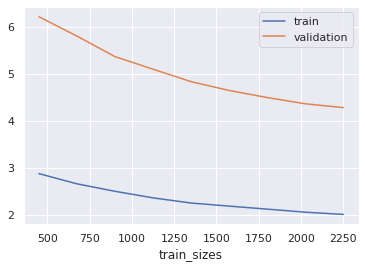

In [ ]:
print_learning_curve(RandomForestRegressor(max_features='sqrt', min_samples_leaf=2, max_depth=None,
                      n_estimators=1000,random_state=0))

Trying to regularize by using only most important features

Training RMSE : 1.08717642438742 (5.1617763118346724% of the mean)
Validation RMSE : 2.076031738193768 (9.8567364122742% of the mean)


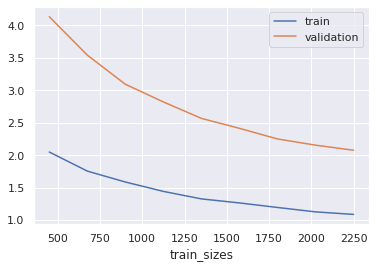

In [ ]:
print_learning_curve(RandomForestRegressor(max_features='sqrt', min_samples_leaf=2, max_depth=None,
                      n_estimators=1000,random_state=0),X=X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']])

In [ ]:
parameters = {
                'max_depth':np.arange(4,14)
                }

grid = GridSearchCV(RandomForestRegressor(n_estimators=1000,random_state=0,min_samples_leaf=2),parameters).fit(X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']],y_train_augmented)

In [ ]:
grid.best_estimator_

RandomForestRegressor(max_depth=13, min_samples_leaf=2, n_estimators=1000,
                      random_state=0)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

print("Training RMSE : "+str(np.sqrt(mean_squared_error(y_train_augmented, grid.best_estimator_.predict(X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']])))))
print("Validation RMSE : "+str(abs(cross_val_score(grid.best_estimator_,X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']],y_train_augmented,scoring="neg_root_mean_squared_error").mean())))

Training RMSE : 0.6965233501843479
Validation RMSE : 1.4797024027935928


Training RMSE : 1.3299830613931938e-14 (6.314591548753405e-14% of the mean)
Validation RMSE : 2.5344384402363582 (12.033193519613473% of the mean)


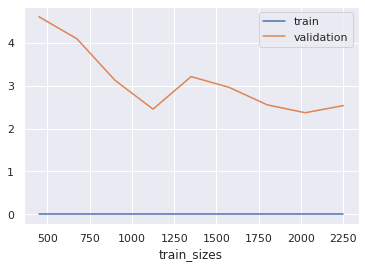

In [ ]:
from sklearn import tree

print_learning_curve(tree.DecisionTreeRegressor(),X_train_augmented)

In [ ]:
tree.plot_tree(tree.DecisionTreeRegressor().fit(X_train_augmented,y_train_augmented))

Training RMSE : 1.3211203871539412e-14 (6.272512691153583e-14% of the mean)
Validation RMSE : 2.1122403200942546 (10.02865018463582% of the mean)


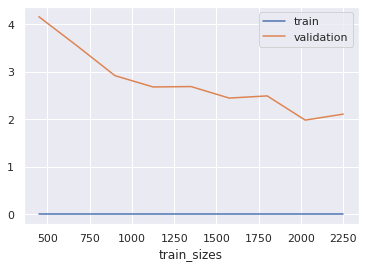

In [ ]:
print_learning_curve(tree.DecisionTreeRegressor(),X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']])

In [ ]:
tree.plot_tree(tree.DecisionTreeRegressor().fit(X_train_augmented,y_train_augmented))

In [ ]:
parameters = {'splitter':('best','random'),'max_depth':[9,10,11,12,13,14],'max_features':["auto","sqrt","log2"]}

grid = GridSearchCV(tree.DecisionTreeRegressor(),parameters).fit(X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']],y_train_augmented)

In [ ]:
grid.best_estimator_

DecisionTreeRegressor(max_depth=14, max_features='auto')

Training RMSE : 0.10279242268370717 (0.4880454363640415% of the mean)
Validation RMSE : 2.064478125393186 (9.80188131835165% of the mean)


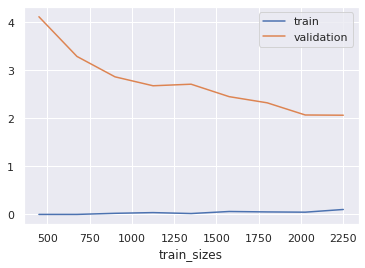

In [ ]:
print_learning_curve(tree.DecisionTreeRegressor(max_depth=14,splitter='best'),X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']])

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

parameters = {'learning_rate':np.linspace(0.01,0.3),'max_iter':[10000],'max_depth':np.arange(3,12,1),'max_leaf_nodes':np.arange(20,3000,50)}

random_search = RandomizedSearchCV(HistGradientBoostingRegressor(),parameters,n_jobs=-1)

In [ ]:
random_search = random_search.fit(X_train_augmented,y_train_augmented)

In [ ]:
random_search.best_estimator_

In [ ]:
print_learning_curve(HistGradientBoostingRegressor(learning_rate=0.04551020408163265, max_depth=8,
                              max_iter=10000, max_leaf_nodes=256))

In [ ]:
model = HistGradientBoostingRegressor(learning_rate=0.04551020408163265, max_depth=8,
                              max_iter=10000, max_leaf_nodes=256,l2_regularization=2).fit(X_train_augmented,y_train_augmented)

categorical_features=[True,True,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True]

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

parameters = {'l2_regularization':np.linspace(0,100),"min_samples_leaf":np.linspace(0,20)}

grid = RandomizedSearchCV(HistGradientBoostingRegressor(learning_rate=0.04551020408163265, max_depth=8,
                              max_iter=10000, max_leaf_nodes=256),parameters,n_jobs=-1)

In [ ]:
grid = grid.fit(X_train_augmented,y_train_augmented)

In [ ]:
grid.best_estimator_

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

print(np.sqrt(mean_squared_error(y_train,grid.best_estimator_.predict(X_train))))
np.sqrt(mean_absolute_error(y_train,grid.best_estimator_.predict(X_train)))

In [ ]:
cross_val_score(HistGradientBoostingRegressor(l2_regularization=32.6530612244898,
                              learning_rate=0.04551020408163265, max_depth=8,
                              max_iter=10000, max_leaf_nodes=256,
                              min_samples_leaf=4.081632653061225),X_train_augmented,y_train_augmented,cv=10,n_jobs=-1,scoring="neg_root_mean_squared_error").mean()

In [ ]:
parameters = {'max_depth':np.arange(3,12,1),'max_leaf_nodes':np.arange(20,3000,10),'min_samples_leaf':np.arange(0,20,1),'l2_regularization':np.arange(0,100,1),"min_samples_leaf":np.arange(0,20,1)}

grid = RandomizedSearchCV(HistGradientBoostingRegressor(learning_rate=0.05,max_iter=10000,early_stopping=True,random_state=0),parameters,n_jobs=-1,scoring="neg_root_mean_squared_error",n_iter=100)

In [ ]:
grid = grid.fit(X_train_augmented,y_train_augmented)

In [ ]:
grid.best_estimator_

HistGradientBoostingRegressor(early_stopping=True, l2_regularization=7,
                              learning_rate=0.05, max_depth=9, max_iter=10000,
                              max_leaf_nodes=1560, min_samples_leaf=4,
                              random_state=0)

In [ ]:
print("Training RMSE : "+str(np.sqrt(mean_squared_error(y_train_augmented,grid.best_estimator_.predict(X_train_augmented)))))
print("Validation RMSE : "+ str(abs(cross_val_score(HistGradientBoostingRegressor(early_stopping=True, l2_regularization=7,
                              learning_rate=0.05, max_depth=9, max_iter=10000,
                              max_leaf_nodes=1560, min_samples_leaf=4,
                              random_state=0),X_train_augmented,y_train_augmented,cv=10,n_jobs=-1,scoring="neg_root_mean_squared_error").mean())))

Training RMSE : 0.6458276989629633
Validation RMSE : 1.7822641443582345


In [ ]:
parameters = {'max_depth':np.arange(3,12,1),'max_leaf_nodes':np.arange(20,3000,10),'min_samples_leaf':np.arange(0,20,1),'l2_regularization':np.arange(0,100,1)}

grid = RandomizedSearchCV(HistGradientBoostingRegressor(learning_rate=0.05,max_iter=10000,early_stopping=True,random_state=0),parameters,n_jobs=-1,scoring="neg_root_mean_squared_error",n_iter=1000)

In [ ]:
grid = grid.fit(X_train_augmented,y_train_augmented)

In [ ]:
grid.best_estimator_

HistGradientBoostingRegressor(early_stopping=True, l2_regularization=13,
                              learning_rate=0.05, max_depth=9, max_iter=10000,
                              max_leaf_nodes=1350, min_samples_leaf=1,
                              random_state=0)

In [ ]:
print("Training RMSE : "+str(np.sqrt(mean_squared_error(y_train_augmented,grid.best_estimator_.predict(X_train_augmented)))))
print("Validation RMSE : "+ str(abs(cross_val_score(HistGradientBoostingRegressor(early_stopping=True, l2_regularization=13,
                              learning_rate=0.05, max_depth=9, max_iter=10000,
                              max_leaf_nodes=1350, min_samples_leaf=1,
                              random_state=0),X_train_augmented,y_train_augmented,cv=10,n_jobs=-1,scoring="neg_root_mean_squared_error").mean())))

Training RMSE : 0.5559899151990154
Validation RMSE : 1.9171539535028095


In [ ]:
test = HistGradientBoostingRegressor(early_stopping=True, l2_regularization=7,
                              learning_rate=0.05, max_depth=9, max_iter=10000,
                              max_leaf_nodes=1560, min_samples_leaf=4,
                              random_state=0).fit(X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']],y_train_augmented)

In [ ]:
print("Training RMSE : "+str(abs(mean_squared_error(y_train_augmented,test.predict(X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']])))))

Training RMSE : 0.48288474686824984


In [ ]:
print("Validation RMSE : "+ str(abs(cross_val_score(HistGradientBoostingRegressor(early_stopping=True, l2_regularization=13,
                              learning_rate=0.05, max_depth=9, max_iter=10000,
                              max_leaf_nodes=1350, min_samples_leaf=1,
                              random_state=0),X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']],y_train_augmented,cv=10,n_jobs=-1,scoring="neg_root_mean_squared_error").mean())))

Validation RMSE : 1.7518685690024274


In [ ]:
test = HistGradientBoostingRegressor(early_stopping=True, l2_regularization=13,
                              learning_rate=0.05, max_depth=9, max_iter=10000,
                              max_leaf_nodes=2^9, min_samples_leaf=1,
                              random_state=0).fit(X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']],y_train_augmented)

In [ ]:
print("Training RMSE : "+str(abs(mean_squared_error(y_train_augmented,test.predict(X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']])))))
print("Validation RMSE : "+ str(abs(cross_val_score(test,X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']],y_train_augmented,cv=10,n_jobs=-1,scoring="neg_root_mean_squared_error").mean())))

Training RMSE : 1.2849341447288003
Validation RMSE : 1.8255532434418213


## Comparaison des modèles

In [ ]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
import sklearn.tree
from sklearn.ensemble import RandomForestRegressor,HistGradientBoostingRegressor

linear_regression = LinearRegression().fit(X_train_augmented_standardized,y_train_augmented)
lasso = Ridge(alpha=90.0).fit(X_train_augmented_standardized,y_train_augmented)
svr = SVR(C=6).fit(X_train_augmented_standardized,y_train_augmented)
tree = sklearn.tree.DecisionTreeRegressor(max_depth=14,splitter='best').fit(X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']],y_train_augmented)
rf = RandomForestRegressor(max_features='sqrt', min_samples_leaf=2, max_depth=13,
                      n_estimators=500,random_state=0).fit(X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']],y_train_augmented)
lightgbm = HistGradientBoostingRegressor(early_stopping=True, l2_regularization=13,
                              learning_rate=0.05, max_depth=9, max_iter=10000,
                              max_leaf_nodes=1350, min_samples_leaf=1,
                              random_state=0).fit(X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']],y_train_augmented)
polynomial = Lasso(alpha=0.18).fit(X_train_poly,y_train_augmented)

In [ ]:
models = pd.Series([linear_regression, lasso, svr, tree, rf, lightgbm,polynomial],index=['linear_regression', 'lasso', 'svr', 'tree', 'rf', 'lightgbm','polynomial'])

from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

for i in range(3):
  print(models.index[i] + " training RMSE : "+ str(np.sqrt(mean_squared_error(y_train_augmented, models[i].predict(X_train_augmented_standardized)))))
  print(models.index[i] + " test RMSE : "+ str(np.sqrt(mean_squared_error(y_test, models[i].predict(X_test)))))

  print(models.index[i] + " training MAE : "+ str(mean_absolute_error(y_train_augmented, models[i].predict(X_train_augmented_standardized))))
  print(models.index[i] + " test MAE : "+ str(mean_absolute_error(y_test, models[i].predict(X_test))))

  print(models.index[i] + " training MedianAE : "+ str(median_absolute_error(y_train_augmented, models[i].predict(X_train_augmented_standardized))))
  print(models.index[i] + " test MedianAE : "+ str(median_absolute_error(y_test, models[i].predict(X_test)))+"\n")


for i in [3,4,5]:
  print(models.index[i] + " training RMSE : "+ str(np.sqrt(mean_squared_error(y_train_augmented, models[i].predict(X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']])))))
  print(models.index[i] + " test RMSE : "+ str(np.sqrt(mean_squared_error(y_test, models[i].predict(X_test[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']])))))

  print(models.index[i] + " training MAE : "+ str(mean_absolute_error(y_train_augmented, models[i].predict(X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']]))))
  print(models.index[i] + " test MAE : "+ str(mean_absolute_error(y_test, models[i].predict(X_test[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']]))))

  print(models.index[i] + " training MedianAE : "+ str(median_absolute_error(y_train_augmented, models[i].predict(X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']]))))
  print(models.index[i] + " test MedianAE : "+ str(median_absolute_error(y_test, models[i].predict(X_test[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']])))+"\n")

linear_regression training RMSE : 8.060899654617302
linear_regression test RMSE : 5826.999398127824
linear_regression training MAE : 6.397085866030282
linear_regression test MAE : 5526.750877658461
linear_regression training MedianAE : 5.299113352550204
linear_regression test MedianAE : 5899.951767493449

lasso training RMSE : 8.061901176149936
lasso test RMSE : 5657.669253396119
lasso training MAE : 6.3842560298635584
lasso test MAE : 5366.091516330892
lasso training MedianAE : 5.258426895896587
lasso test MedianAE : 5728.257856635986

svr training RMSE : 6.2245934220671915
svr test RMSE : 7.338933521356885
svr training MAE : 3.480781068552646
svr test MAE : 5.841575639021444
svr training MedianAE : 1.050638881349947
svr test MedianAE : 5.5720682872656715

tree training RMSE : 1.5398989431549096e-14
tree test RMSE : 11.625278243534359
tree training MAE : 1.0810136383715239e-14
tree test MAE : 9.072889578739803
tree training MedianAE : 8.881784197001252e-15
tree test MedianAE : 6.07961

In [ ]:
pd.DataFrame([y_test[['%']],pd.DataFrame(rf.predict(X_test[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']]))] ,columns=['true values'])

ValueError: ignored

In [ ]:
pd.concat(pd.DataFrame(rf.predict(X_test[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']]))

AttributeError: ignored